In [53]:
import matplotlib.pyplot as plt
import pandas as pd

In [54]:
data = pd.read_csv('ibm_data.csv')
data

,time_of_intro,year,1_generation,2_generation,familiy_360,famili_370,total
0,NaN,1955,190.0,NaN,NaN,NaN,190
1,NaN,1956,560.0,NaN,NaN,NaN,560
2,NaN,1957,1000.0,NaN,NaN,NaN,1000
3,NaN,1958,1680.0,NaN,NaN,NaN,1680
4,T2,1959,2542.0,3.0,NaN,NaN,2545
5,NaN,1960,2640.0,880.0,NaN,NaN,3520
6,NaN,1961,2350.0,2510.0,NaN,NaN,4860
7,NaN,1962,1820.0,4725.0,NaN,NaN,6545
8,NaN,1963,1170.0,7720.0,NaN,NaN,8890
9,NaN,1964,750.0,10940.0,NaN,NaN,11690


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sympy import solve, Eq, symbols


# starting parameters
def define_Q_and_n(n_=3, Q00=10, Q01=20, Q02=50, Q03=100):
    n = n_
    Q = [Q00, Q01, Q02, Q03]
    return n, Q


def define_parameters(s0=0.1, s1=0.4, s2=0.65, q0=0.2, q1=0.2, q2=0, q3=0,
                      p0=0.5, p1=0.3, p2=0.3, p3=0.9, r0=0.2, r1=0.1, r2=0.05, r3=0.1):
    s = [s0, s1, s2]
    q = [q0, q1, q2, q3]
    p = [p0, p1, p2, p3]
    r = [r0, r1, r2, r3]

    return s, q, p, r


def new_clients(Q, *args):
    srednia = sum(Q) / len(Q)
    srednia = srednia / args[0]
    variance = args[1]
    x, y = symbols('x y')
    eq1 = Eq(srednia - x * y, 0)
    eq2 = Eq(variance - x * y * y, 0)
    sol = solve((eq1, eq2), (x, y))[0]
    return np.random.gamma(sol[0], sol[1])


def define_starting_df(n, Q):
    names = ['Q' + str(i) for i in range(n + 1)]
    df = pd.DataFrame(0, index=np.arange(1), columns=names)
    for j in range(n + 1):
        df.iloc[0, j] = Q[j]
    return df


def next_year(df, df2, n, t, s, q, p, k3, k2):
    row = [0] * (n + 1)
    t = t + 1
    for j in range(n + 1):
        if j != n and j != n - 1:
            row[j] = round(s[j] * df.iloc[t - 1][-(n - j + 1)])
        elif j == n - 1:
            row[j] = round(s[j] * df.iloc[t - 1][-(n - j + 1)])
            for i in range(n + 1):
                row[j] += round(q[i] * df.iloc[t - 1][-n + i - 1])
            row[j] += round(k2)
        elif j == n:
            for i in range(n + 1):
                row[j] += round(p[i] * df.iloc[t - 1][-n + i - 1])
            row[j] += round(k3)
    size = len(df.columns)
    no_zeros = size - (n + 1)
    list_zeros = [0] * no_zeros
    row = list_zeros + row
    df.loc[t] = row

    new_users_1 = 0
    for l in range(n):
        new_users_1 += round(p[l] * df.iloc[t - 1][-n + l - 1])
    new_users_1 += round(k3)
    new_users_2 = 0
    for l in range(n):
        new_users_2 += round(q[l] * df.iloc[t - 1][-n + l - 1])
    new_users_2 += round(k2)
    last_row = df2.loc[t - 1]
    last_row[-1] += new_users_1
    if len(last_row) > 1:
        last_row[-2] += new_users_2
    df2.loc[t] = last_row
    return df, df2, t


def new_generation(df, df2):
    last_name = df.columns[-1]
    number_of_new_gen = str(int(last_name[1:]) + 1)
    new_name = 'Q' + number_of_new_gen
    df[new_name] = 0
    df2[new_name] = 0
    return df, df2


def create_number_of_users_df(n, Q):
    names = ['Q' + str(n)]
    df = pd.DataFrame(0, index=np.arange(1), columns=names)
    df.iloc[0, 0] = Q[n]
    return df


def plot_df(df, title):
    df.plot.line(title=title)

#checks if parameters sum to 1
def check(s, q, p, r):
    for i in range(len(s)):
        if math.isclose(s[i]+q[i]+p[i]+r[i],1):
            continue
        else:
            raise ValueError("ValueError exception thrown")
    return 0
        

In [56]:

if __name__ == '__main__':
    t = 0
    n, Q = define_Q_and_n(n_=3, Q00=0, Q01=49, Q02=4646, Q03=17687)
    # parametry dla roku gdy w poprzednim nie weszła nowa generacja (Moze ktos poprobowac ktore beda dobre)
    s, q, p, r = define_parameters(s0=0.4, s1=0.75, s2=0.85, q0=0.05, q1=0.05, q2=0, q3=0,
                      p0=0.1, p1=0.1, p2=0.1, p3=0.99, r0=0.45, r1=0.1, r2=0.05, r3=0.01)
    
    check(s,q,p,r)

    # parametry dla roku gdy w poprzednim  weszla nowa generacja
    s_, q_, p_, r_ = define_parameters(s0=0.4, s1=0.75, s2=0.85, q0=0.05, q1=0.05, q2=0, q3=0,
                      p0=0.1, p1=0.1, p2=0.1, p3=0.99, r0=0.45, r1=0.1, r2=0.05, r3=0.01)
    df1 = define_starting_df(n, Q)
    df2 = create_number_of_users_df(n, Q)
    k3 = new_clients(Q, 20, 5)
    k2 = new_clients(Q, 60, 5)

    df1, df2, t = next_year(df1, df2, n, t, s, q, p, k3, k2)
    
    df1, df2 = new_generation(df1, df2)
    
    df1, df2, t = next_year(df1, df2, n, t, s_, q_, p_, k3, k2)
    
    #czas na pojawienei sie kolejnej genracji
    for i in range(7):
        df1, df2, t = next_year(df1, df2, n, t, s, q, p, k3, k2)

In [57]:
years = range(1969,1979)
slownik1={'1_generation':'black','2_generation':'green','familiy_360':'darkred','famili_370':'blue'}
slownik2={'Q4':'skyblue','Q3':'lightcoral','Q2':'lime','Q1':'gray'}
df = data.iloc[14:]
df1

,Q0,Q1,Q2,Q3,Q4
0,0.0,49.0,4646.0,17687.0,0.0
1,0.0,37.0,4043.0,18260.0,0.0
2,0.0,15.0,3032.0,15817.0,2514.0
3,0.0,6.0,2274.0,13689.0,4656.0
4,0.0,2.0,1706.0,11842.0,6486.0
5,0.0,1.0,1280.0,10243.0,8056.0
6,0.0,0.0,960.0,8863.0,9407.0
7,0.0,0.0,720.0,7674.0,10575.0
8,0.0,0.0,540.0,6651.0,11588.0
9,0.0,0.0,405.0,5772.0,12471.0


In [58]:
df

,time_of_intro,year,1_generation,2_generation,familiy_360,famili_370,total
14,NaN,1969,49.0,4646.0,17687.0,NaN,22382
15,NaN,1970,29.0,3297.0,19412.0,NaN,22738
16,T4,1971,14.0,2916.0,17529.0,806.0,21265
17,NaN,1972,6.0,2384.0,14909.0,2922.0,20221
18,NaN,1973,4.0,2079.0,10475.0,5887.0,18445
19,NaN,1974,4.0,1676.0,8060.0,8440.0,18180
20,NaN,1975,3.0,1397.0,6450.0,9335.0,17185
21,NaN,1976,NaN,1107.0,5919.0,9046.0,16072
22,NaN,1977,NaN,894.0,5118.0,10450.0,16462
23,NaN,1978,NaN,829.0,4641.0,11348.0,16818


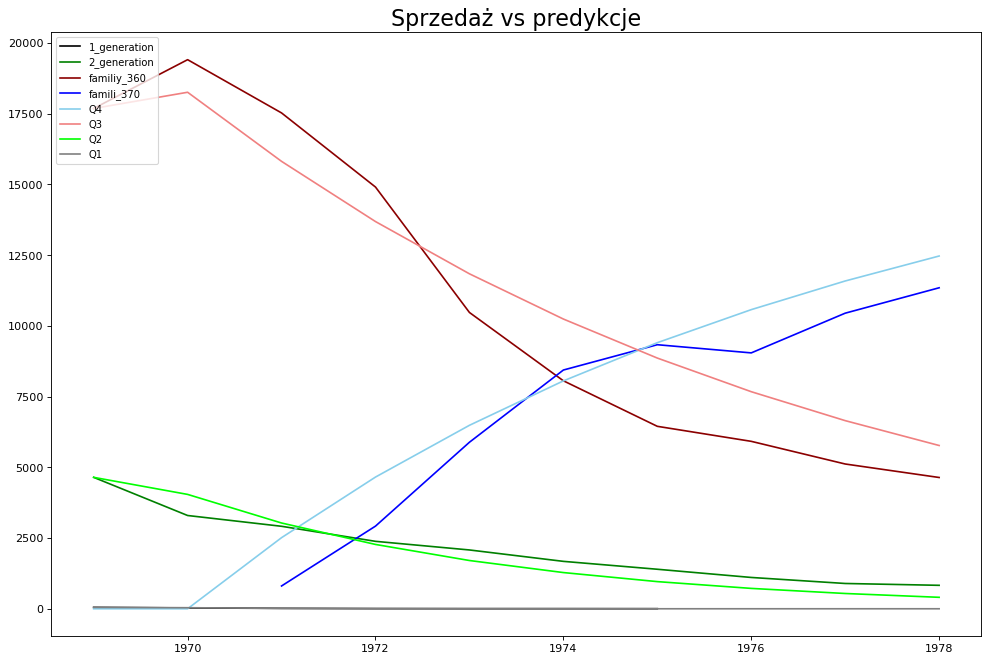

In [59]:
plt.figure(figsize=(15, 10), dpi=80)
plt.title("Sprzedaż vs predykcje", fontsize=20)

for name, color in slownik1.items():
    plt.plot(years,df[name], label=name, c=color)
    
for name, color in slownik2.items():
    plt.plot(years,df1[name], label=name, c=color)

    
plt.legend(loc=2,prop={'size':9})
plt.savefig('prediction1_1.png')

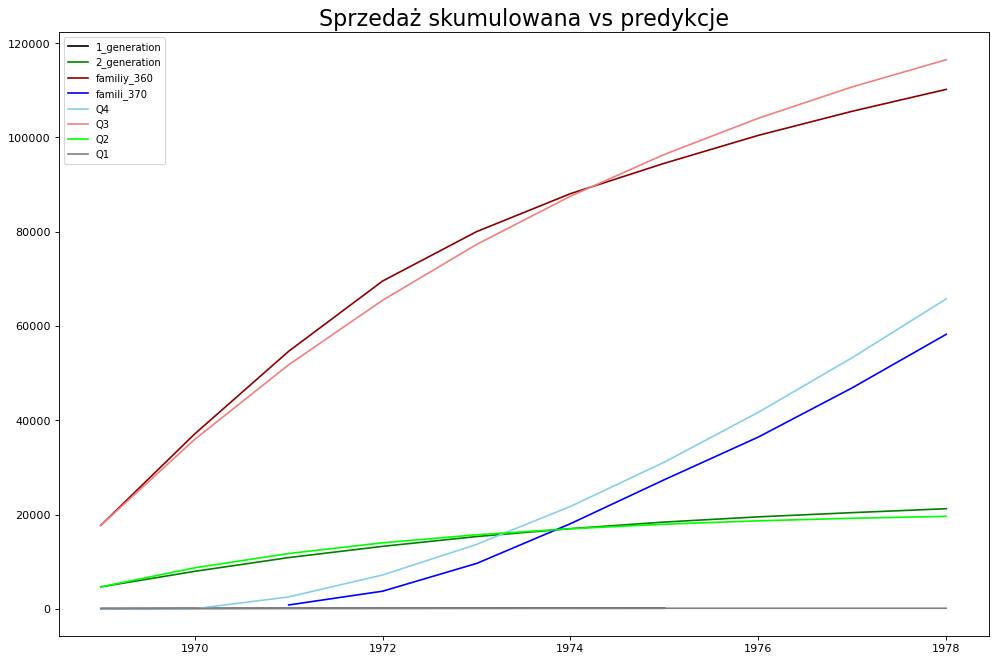

In [60]:
plt.figure(figsize=(15, 10), dpi=80)

plt.title("Sprzedaż skumulowana vs predykcje", fontsize=20)
for name, color in slownik1.items():
    plt.plot(years, df[name].cumsum(), label=name, c=color)
    
for name, color in slownik2.items():
    plt.plot(years, df1[name].cumsum(), label=name, c=color)


plt.legend(loc=2,prop={'size':9})
plt.savefig('prediction1_2.png')

In [61]:
from sklearn.metrics import mean_squared_error


x = df1['Q4'].fillna(0).cumsum()
y = df['famili_370'].fillna(0).cumsum()


rms = np.sqrt(mean_squared_error(x, y))
rms

4283.271413300819

In [62]:
###Second situation


if __name__ == '__main__':
    t = 0
    n, Q = define_Q_and_n(n_=3, Q00=0, Q01=0, Q02=1170, Q03=7720)
    # parametry dla roku gdy w poprzednim nie weszła nowa generacja (Moze ktos poprobowac ktore beda dobre)
    s, q, p, r = define_parameters(s0=0.4, s1=0.75, s2=0.85, q0=0.05, q1=0.05, q2=0, q3=0,
                      p0=0.1, p1=0.1, p2=0.1, p3=0.99, r0=0.45, r1=0.1, r2=0.05, r3=0.01)
    
    check(s,q,p,r)

    # parametry dla roku gdy w poprzednim  weszla nowa generacja
    s_, q_, p_, r_ = define_parameters(s0=0.4, s1=0.75, s2=0.85, q0=0.05, q1=0.05, q2=0, q3=0,
                      p0=0.1, p1=0.1, p2=0.1, p3=0.99, r0=0.45, r1=0.1, r2=0.05, r3=0.01)
    df1 = define_starting_df(n, Q)
    df2 = create_number_of_users_df(n, Q)
    k3 = new_clients(Q, 2, 5)
    k2 = new_clients(Q, 15, 5)

    df1, df2, t = next_year(df1, df2, n, t, s, q, p, k3, k2)
    
    df1, df2 = new_generation(df1, df2)
    
    #czas na pojawienei sie kolejnej genracji
    for i in range(6):
        df1, df2, t = next_year(df1, df2, n, t, s, q, p, k3, k2)
        
    df1, df2 = new_generation(df1, df2)
    for i in range(8):
        df1, df2, t = next_year(df1, df2, n, t, s, q, p, k3, k2)    

df1

,Q0,Q1,Q2,Q3,Q4,Q5
0,0.0,0.0,1170.0,7720.0,0.0,0.0
1,0.0,0.0,1143.0,8872.0,0.0,0.0
2,0.0,0.0,857.0,7747.0,2113.0,0.0
3,0.0,0.0,643.0,6777.0,4065.0,0.0
4,0.0,0.0,482.0,5941.0,5878.0,0.0
5,0.0,0.0,362.0,5223.0,7573.0,0.0
6,0.0,0.0,272.0,4607.0,9167.0,0.0
7,0.0,0.0,204.0,4079.0,10675.0,0.0
8,0.0,0.0,82.0,3059.0,9437.0,2608.0
9,0.0,0.0,33.0,2294.0,8327.0,4952.0


In [63]:
years = range(1963,1979)
slownik1={'1_generation':'black','2_generation':'green','familiy_360':'darkred','famili_370':'blue'}
slownik2={'Q5':'skyblue','Q4':'lightcoral','Q3':'lime','Q2':'gray'}
df = data.iloc[8:]
df

,time_of_intro,year,1_generation,2_generation,familiy_360,famili_370,total
8,NaN,1963,1170.0,7720.0,NaN,NaN,8890
9,NaN,1964,750.0,10940.0,NaN,NaN,11690
10,T3,1965,455.0,13090.0,625.0,NaN,14170
11,NaN,1966,303.0,13330.0,3881.0,NaN,17514
12,NaN,1967,203.0,9977.0,8125.0,NaN,18305
13,NaN,1968,170.0,6896.0,13110.0,NaN,20176
14,NaN,1969,49.0,4646.0,17687.0,NaN,22382
15,NaN,1970,29.0,3297.0,19412.0,NaN,22738
16,T4,1971,14.0,2916.0,17529.0,806.0,21265
17,NaN,1972,6.0,2384.0,14909.0,2922.0,20221


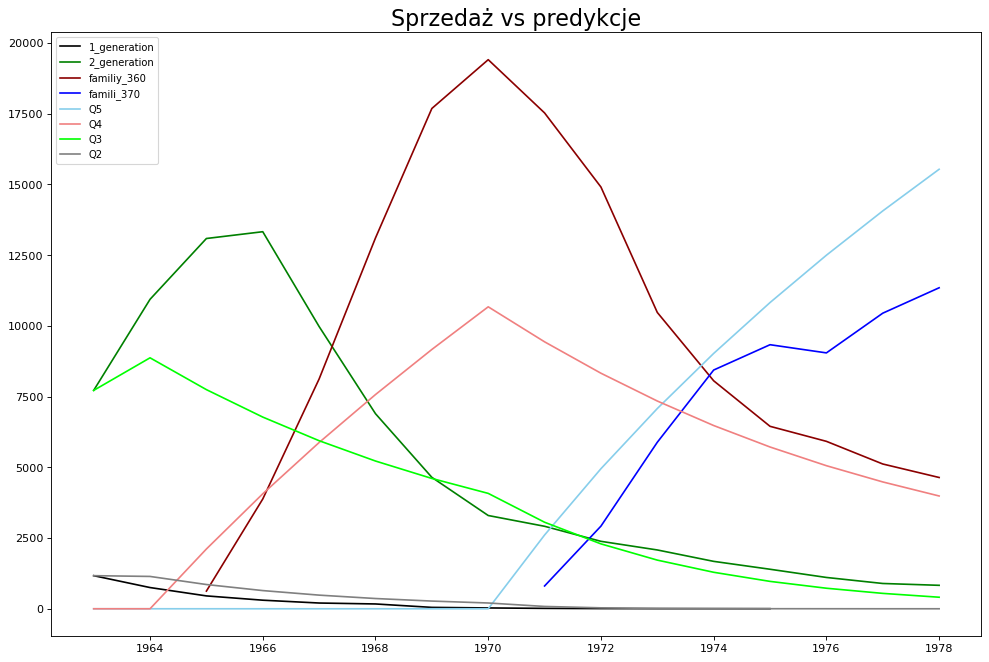

In [64]:
plt.figure(figsize=(15, 10), dpi=80)
plt.title("Sprzedaż vs predykcje", fontsize=20)

for name, color in slownik1.items():
    plt.plot(years,df[name], label=name, c=color)
    
for name, color in slownik2.items():
    plt.plot(years,df1[name], label=name, c=color)

    
plt.legend(loc=2,prop={'size':9})
plt.savefig('prediction2_1.png')

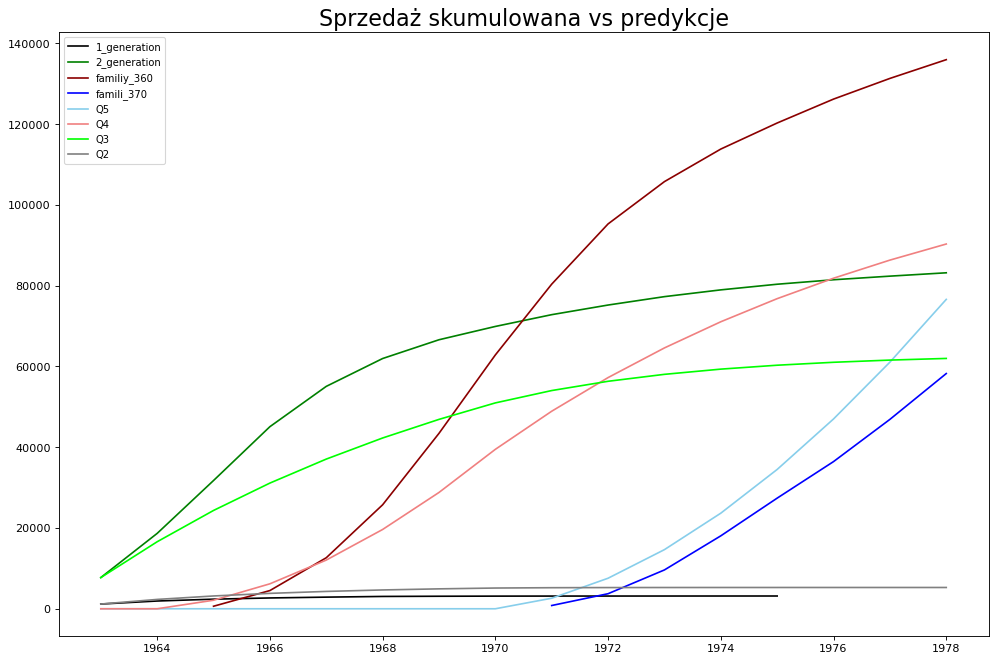

In [65]:
plt.figure(figsize=(15, 10), dpi=80)

plt.title("Sprzedaż skumulowana vs predykcje", fontsize=20)
for name, color in slownik1.items():
    plt.plot(years, df[name].cumsum(), label=name, c=color)
    
for name, color in slownik2.items():
    plt.plot(years, df1[name].cumsum(), label=name, c=color)


plt.legend(loc=2,prop={'size':9})
plt.savefig('prediction2_2.png')

In [66]:
from sklearn.metrics import mean_squared_error


x = df1['Q5'].fillna(0).cumsum()
y = df['famili_370'].fillna(0).cumsum()


rms = np.sqrt(mean_squared_error(x, y))
rms

6956.9221553069